In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
from tqdm import tqdm
import time

## Tools for loading the program versions

In [2]:

def compile_version(version, output=False):
    try:
        result = subprocess.check_output(f"module load daint-gpu && module switch PrgEnv-gnu PrgEnv-cray && module load perftools-lite && cd fortran_programs && make VERSION={version} ", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
        print(f"Version {version} succeeded")

    except subprocess.CalledProcessError as cpe:
        result = cpe.output

    finally:   
        if output:
            for line in result.splitlines():
                print(line.decode())

def compile_all_versions(versions, output=False, clean_old=False):
    if clean_old:
        print("Remove all old outputs")
        subprocess.run(f"cd fortran_programs && make clean", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
    else:
        print("Not removing previously compiled programs")
    for version in versions:
        compile_version(version, output)

In [3]:
!gfortran -fopenacc -c fortran_programs/m_utils.F90 -o fortran_programs/m_utils.o
!gfortran -fopenacc -o fortran_programs/stencil2d-GPU fortran_programs/stencil2d-GPU.F90

fortran_programs/m_utils.F90:11:8:

   11 |     use mpi, only : MPI_COMM_WORLD, MPI_Abort
      |        1
Fatal Error: Cannot open module file 'mpi.mod' for reading at (1): No such file or directory
compilation terminated.
fortran_programs/stencil2d-GPU.F90:11:8:

   11 |     use m_utils, only: timer_start, timer_end, timer_get, is_master, num_rank, write_field_to_file
      |        1
Fatal Error: Cannot open module file 'm_utils.mod' for reading at (1): No such file or directory
compilation terminated.


In [4]:
versions = ["GPU","5th_GPT","OpenMP_GPT","orig","kblock"]

In [5]:
compile_all_versions(versions, output=False, clean_old=True)

Remove all old outputs
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
Version GPU succeeded
Version 5th_GPT succeeded
Version OpenMP_GPT succeeded
Version orig succeeded
Version kblock succeeded


In [6]:
def execute_version(version, nx=64, ny=64, nz=64, num_iter=1024, attempt=0):
    try:
        result = subprocess.check_output(f"cd fortran_programs && srun -n 12 ./stencil2d-{version}.x+orig --nx {nx} --ny {ny} --nz {nz} --num_iter {num_iter}", shell = True, executable = "/bin/bash", stderr = subprocess.STDOUT)
    except subprocess.CalledProcessError as cpe:
        print("there was an error")
        result = cpe.output
    code_string = result.decode()
    if "Job" in code_string and attempt < 5: 
        print(f"Job failed with the code {code_string}")
        print(f"It was attempt {attempt}, trying again")
        time.sleep(1)  # not sure if needed, but maybe give server some time to rest? 
        return execute_version(version, nx=nx, ny=ny, nz=nz, num_iter=num_iter, attempt=attempt+1)
    elif "Job" in code_string and attempt == 5:
        print("Servers are busy, ending now")
        return
    exec(code_string, None, globals() )
    return data

def execute_versions(versions, nx=64, ny=64, nz=64, num_iter=1024):
    result = {}
    for version in versions:
        data = execute_version(version, nx=nx, ny=ny, nz=nz, num_iter=num_iter)
        result[version] = data
    return result
    

In [7]:
result = execute_version("GPU", num_iter=128)
print(result)

[[ 12.         64.         64.         64.        128.          0.3155266]]


In [8]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('fortran_programs/in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('fortran_programs/out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

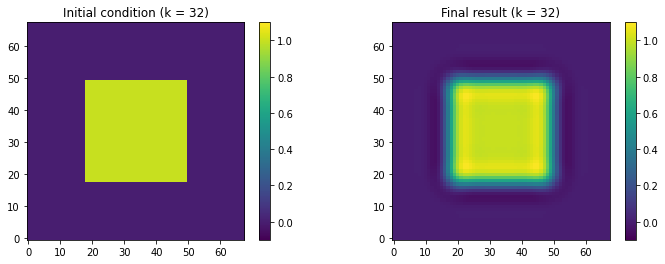

In [9]:
validate_results()

In [10]:
def get_scan_data(version, nxs, nys, nz, num_iter):
    data_sizes = []
    times = []
    print(f"Executing version {version}")
    for nx in tqdm(nxs):
        for ny in nys: 
            runtime = execute_version(version, nx=nx, ny=ny, nz=nz, num_iter=num_iter)[0][-1]
            data_sizes.append(nx * ny * nz * 3 * 4)
            times.append(runtime)
    return np.array(data_sizes), np.array(times)

Executing version GPU


100%|██████████| 4/4 [00:23<00:00,  5.98s/it]


Executing version 5th_GPT


 75%|███████▌  | 3/4 [00:24<00:08,  8.25s/it]

Job failed with the code srun: Job 55853908 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 55853908
# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,   64,   64,   64,     128,  0.2755261E+00], \
] )

It was attempt 0, trying again


100%|██████████| 4/4 [00:36<00:00,  9.21s/it]


Executing version orig


 25%|██▌       | 1/4 [00:07<00:21,  7.18s/it]

Job failed with the code srun: Job 55853908 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 55853908
# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,   32,   64,   64,     128,  0.3523628E-01], \
] )

It was attempt 0, trying again


100%|██████████| 4/4 [00:35<00:00,  8.90s/it]


Executing version kblock


 25%|██▌       | 1/4 [00:08<00:24,  8.13s/it]

Job failed with the code srun: Job 55853908 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 55853908
# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,   32,   16,   64,     128,  0.8503377E-02], \
] )

It was attempt 0, trying again


100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


Executing version OpenMP_GPT


  0%|          | 0/4 [00:00<?, ?it/s]

Job failed with the code srun: Job 55853908 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 55853908
# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,   16,   16,   64,     128,  0.5850255E-02], \
] )

It was attempt 0, trying again


 75%|███████▌  | 3/4 [00:23<00:07,  7.60s/it]

Job failed with the code srun: Job 55853908 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 55853908
# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,   64,   48,   64,     128,  0.1674118E+00], \
] )

It was attempt 0, trying again


100%|██████████| 4/4 [00:32<00:00,  8.23s/it]


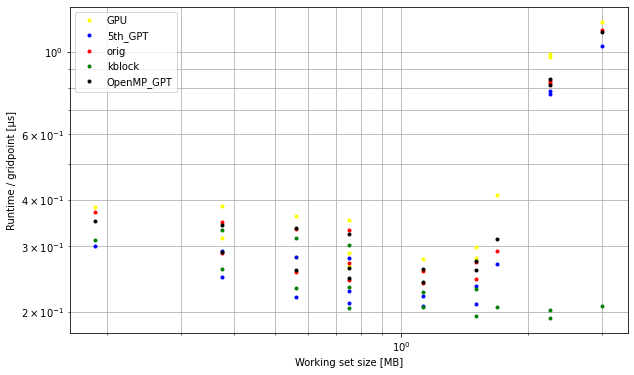

In [11]:
nxs = 16 * np.array([1, 2, 3, 4])
nys = 16 * np.array([1, 2, 3, 4])
nz = 64
num_iter = 128
versions = ["GPU","5th_GPT","orig", "kblock","OpenMP_GPT"]
colors = ["yellow","blue", "red","green","black"]
for version, color in zip(versions, colors):
    data_sizes, times = get_scan_data(version, nxs, nys, nz, num_iter)
    plt.loglog(data_sizes/ 1024. / 1024., times / data_sizes * 3 * 4 * 1e6, ".", label=version, color=color)
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(visible=True, which='both')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
plt.legend(loc="upper left")